In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from itertools import combinations
from tqdm import tqdm
from collections import Counter, defaultdict

from sklearn import metrics, preprocessing

from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
df, embeds = read_preds('../data/ava-lstm-attn/')

100%|██████████| 283/283 [00:14<00:00, 18.93it/s]


In [20]:
rows = []
for r in df[(df.split=='train')&(df.domain=='huffingtonpost.com')].to_dict('records'):
    for w in r['windows']:
        rows.append((w, r['p_buzzfeed.com']))

In [21]:
pdf = pd.DataFrame(rows, columns=('w', 'p'))

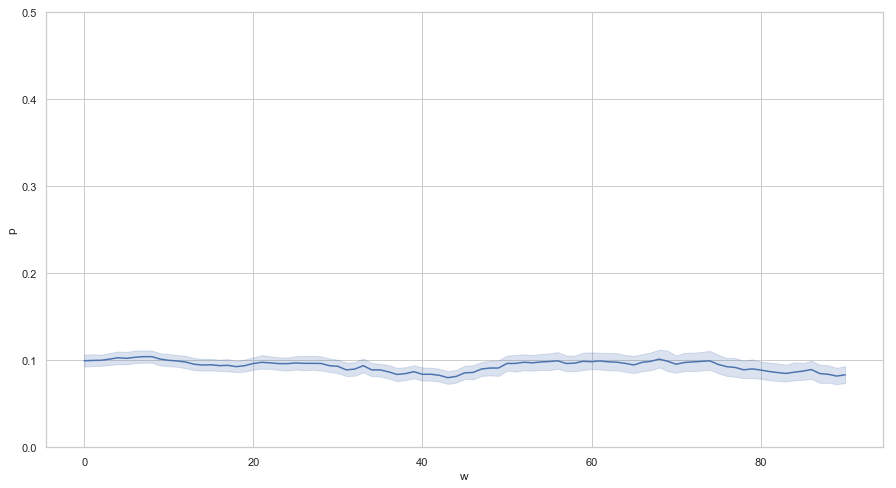

In [23]:
plt.figure(figsize=(15,8))
plt.ylim(0, 0.5)
sns.lineplot(x='w', y='p', data=pdf)

In [3]:
DOMAINS = list(df.domain.unique())

In [6]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.domain}'], 1)
df['pred'] = df.apply(lambda r: DOMAINS[np.argmax([r[f'p_{d}'] for d in DOMAINS])], 1)

In [9]:
df_train = df[df.split=='train']

In [27]:
pairs = [sorted(p) for p in combinations(DOMAINS, 2)]

In [130]:
rows = []
for d1, d2 in tqdm(pairs):
    d1p = df_train[f'p_{d1}']
    d2p = df_train[f'p_{d2}']
    pr_corr, _ = stats.pearsonr(d1p, d2p)
    kt_corr, _ = stats.kendalltau(d1p, d2p)
    sp_corr, _ = stats.spearmanr(d1p, d2p)
    rows.append((d1, d2, pr_corr, kt_corr, sp_corr))

100%|██████████| 105/105 [00:14<00:00,  7.45it/s]


In [132]:
corr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'pr_corr', 'kt_corr', 'sp_corr'))
corr_df['pair'] = corr_df.apply(lambda r: f'{r.d1} - {r.d2}', axis=1)

In [133]:
for c1, c2 in combinations(['pr_corr', 'kt_corr', 'sp_corr'], 2):
    print(c1, c2, stats.kendalltau(corr_df[c1], corr_df[c2]))

pr_corr kt_corr KendalltauResult(correlation=0.734065934065934, pvalue=1.286975834233892e-28)
pr_corr sp_corr KendalltauResult(correlation=0.734065934065934, pvalue=1.286975834233892e-28)
kt_corr sp_corr KendalltauResult(correlation=0.983150183150183, pvalue=5.695818513863508e-50)


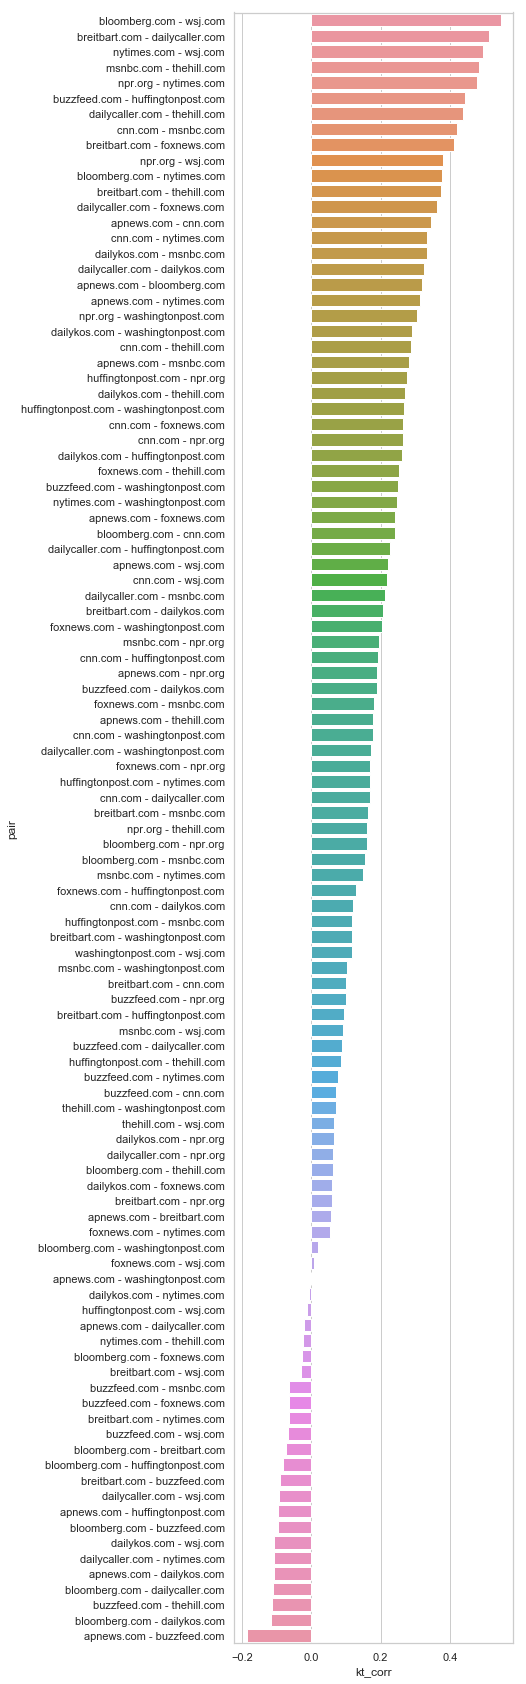

In [134]:
col = 'kt_corr'
order = corr_df.sort_values(col, ascending=False).pair
plt.figure(figsize=(5,30))
sns.barplot(x=col, y='pair', data=corr_df, order=order)

In [212]:
rows = defaultdict(dict)

for d1 in DOMAINS:
    
    ddf = df_train[df_train.domain==d1]
    counts = Counter(ddf.pred)
    
    for d2, count in counts.items():
        if d1 != d2:
            rows[d1, d2]['misc_count'] = count
            
for r in corr_df.itertuples():
    for name in ('pr_corr', 'kt_corr', 'sp_corr'):
        rows[r.d1, r.d2][name] = getattr(r, name)
        rows[r.d2, r.d1][name] = getattr(r, name)

In [217]:
cdf = pd.DataFrame([
    dict(d1=d1, d2=d2, **cols)
    for (d1, d2), cols in rows.items()
])

In [218]:
cdf

,d1,d2,kt_corr,misc_count,pr_corr,sp_corr
0,breitbart.com,thehill.com,0.375238,1258,0.000105,0.526036
1,breitbart.com,foxnews.com,0.411613,614,0.082881,0.574753
2,breitbart.com,msnbc.com,0.163371,719,-0.110645,0.243843
3,breitbart.com,dailycaller.com,0.512318,727,0.220853,0.697113
4,breitbart.com,wsj.com,-0.028693,307,-0.138920,-0.030124
5,breitbart.com,dailykos.com,0.206616,613,-0.067808,0.301632
6,breitbart.com,huffingtonpost.com,0.095080,395,-0.093701,0.143586
7,breitbart.com,apnews.com,0.057444,551,-0.096679,0.087256
8,breitbart.com,npr.org,0.058225,227,-0.119748,0.095242
9,breitbart.com,nytimes.com,-0.065126,201,-0.168998,-0.077272


In [220]:
cdf.to_json('data/headline-graph-ava.json', orient='records', lines=True)